In [233]:
# type: ignore
from memo import memo
import jax 
import jax.numpy as np
from jax.scipy.stats.beta import pdf as beta_pdf
beta_pdf = jax.jit(beta_pdf)

from enum import IntEnum
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_context('poster')

## Build the authority and observer models

In [275]:
# type: ignore

class Actions(IntEnum): 
    NONE = 0
    PUNISH = 1

class Prior(IntEnum):
    PRIOR = 0

# wrongness and alpha_justice are continuous variables in [0,1] 
UnitRange = np.linspace(0, 1, 100)

@jax.jit
def u_target(action):
    # if punish, then negative U_target, else 0
    U_target = jax.lax.cond(action == Actions.PUNISH, lambda x: -1, lambda x: 0, None) 
    return U_target


@jax.jit
def u_justice(action, wrongness):
    # the more wrong an act is the lower the utility caused by the transgression
    # and later on the harsher punishment it would deserve
    u_transgression = -1 * wrongness
    harshness = u_transgression - u_target(action)
    u_justice = np.where(harshness > 0, -1 * harshness, harshness)
     
    return u_justice

@jax.jit
def u_total(action, wrongness, alpha_justice):
    alpha_target = 0.5  # TODO: we can make this a random variable as well
    return alpha_target * u_target(action) + alpha_justice * u_justice(action, wrongness)

In [235]:
# type: ignore
@memo
def authority[action: Actions, wrongness: UnitRange, alpha_justice: UnitRange](beta): 
    # cast: [actor, observer]
    authority: knows(wrongness, alpha_justice)
    authority: chooses(action in Actions, wpp=exp(beta * u_total(action, wrongness, alpha_justice)))
    return Pr[authority.action == action]

In [236]:
# type: ignore
@memo
def observer[action: Actions, wrongness: UnitRange, alpha_justice: UnitRange](beta, a_wrongness, b_wrongness, a_justice, b_justice): 
    # cast: [actor, observer]
    observer: knows(wrongness, alpha_justice)
    observer: thinks[
        authority: given(wrongness in UnitRange, wpp=beta_pdf(wrongness, a_wrongness, b_wrongness)),
        authority: given(alpha_justice in UnitRange, wpp=beta_pdf(alpha_justice, a_justice, b_justice)),
        authority: chooses(action in Actions, wpp=authority[action, wrongness, alpha_justice](beta))
    ] 
    observer: observes[authority.action] is action
    
    return observer[Pr[authority.wrongness == wrongness, authority.alpha_justice == alpha_justice]]

In [278]:
# type: ignore
@memo
def observer_priors[action: Prior, wrongness: UnitRange, alpha_justice: UnitRange](beta, a_wrongness, b_wrongness, a_justice, b_justice): 
    # cast: [actor, observer]
    observer_priors: knows(wrongness, alpha_justice, action)
    observer_priors: thinks[
        authority: given(wrongness in UnitRange, wpp=beta_pdf(wrongness, a_wrongness, b_wrongness)),
        authority: given(alpha_justice in UnitRange, wpp=beta_pdf(alpha_justice, a_justice, b_justice))
    ]
    
    return observer_priors[Pr[authority.wrongness == wrongness, authority.alpha_justice == alpha_justice]]

## Simulate observer with specific priors

In [363]:
a_wrongness = 1
b_wrongness = 1
a_justice = 4
b_justice = 1
beta = 3

observer_inferences = observer(beta, a_wrongness, b_wrongness, a_justice, b_justice, return_pandas=True)[1].pandas
observer_prior_beliefs = observer_priors(beta, a_wrongness, b_wrongness, a_justice, b_justice, return_pandas=True)[1].pandas

In [364]:
observer_prior_beliefs.rename(columns={'observer_priors': 'observer'}, inplace=True)

In [365]:
observer_inferences

,action,wrongness,alpha_justice,observer
0,NONE,0.0,0.000000,0.000000e+00
1,NONE,0.0,0.010101,4.511903e-10
2,NONE,0.0,0.020202,3.628798e-09
3,NONE,0.0,0.030303,1.231097e-08
4,NONE,0.0,0.040404,2.932974e-08
...,...,...,...,...
19995,PUNISH,1.0,0.959596,1.090049e-03
19996,PUNISH,1.0,0.969697,1.131632e-03
19997,PUNISH,1.0,0.979798,1.174248e-03
19998,PUNISH,1.0,0.989899,1.217907e-03


In [366]:
## Helper functions for finding the marginal distribution and expected value of wrongness and alpha_justice separately
def marginalize(joint_dist, variable_name):
    if variable_name not in ['wrongness', 'alpha_justice']:
        raise ValueError("variable name doesn't exist!")
    marginalized_df = joint_dist.groupby(['action', variable_name])['observer'].sum().reset_index()
    return marginalized_df

def expected_value(marginalized_dist, variable_name):
    if variable_name not in ['wrongness', 'alpha_justice']:
        raise ValueError("variable name doesn't exist!")
    expected_value = (marginalized_dist.groupby('action')
                      .apply(lambda df: (df[variable_name] * df['observer']).sum(), include_groups=False)
                      .reset_index(name=f'expected_{variable_name}'))
    return expected_value

In [367]:
# Find the marginal distribution and expected value of wrongness and alpha_justice 
# For priors
wrongness_dist_prior = marginalize(observer_prior_beliefs, 'wrongness')
wrongness_value_prior = expected_value(wrongness_dist_prior, 'wrongness')
alpha_justice_dist_prior = marginalize(observer_prior_beliefs, 'alpha_justice')
alpha_justice_value_prior = expected_value(alpha_justice_dist_prior, 'alpha_justice')

# For posteriors
wrongness_dist_posterior = marginalize(observer_inferences, 'wrongness')
wrongness_value_posterior = expected_value(wrongness_dist_posterior, 'wrongness')
alpha_justice_dist_posterior = marginalize(observer_inferences, 'alpha_justice')
alpha_justice_value_posterior = expected_value(alpha_justice_dist_posterior, 'alpha_justice')

# Concatenate the prior and posteriors for plotting
wrongness_dist = pd.concat([wrongness_dist_prior, wrongness_dist_posterior], ignore_index=True)
wrongness_value = pd.concat([wrongness_value_prior, wrongness_value_posterior], ignore_index=True)
alpha_justice_dist = pd.concat([alpha_justice_dist_prior, alpha_justice_dist_posterior], ignore_index=True)
alpha_justice_value = pd.concat([alpha_justice_value_prior, alpha_justice_value_posterior], ignore_index=True)

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_distribution(ax, marginalized_df, expected_df, variable_name):
    """
    Plots the marginalized distribution as a violin plot with expected values overlaid on a given axis.
    
    Parameters:
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        marginalized_df (pd.DataFrame): DataFrame with columns ['action', variable_name, 'observer'].
        expected_df (pd.DataFrame): DataFrame with columns ['action', f'expected_{variable_name}'].
        variable_name (str): The name of the variable to plot (e.g., 'wrongness' or 'alpha_justice').
    """
    color = 'red' if variable_name == 'wrongness' else 'blue'

    # Resample data according to probability mass function
    resampled_data = marginalized_df.loc[
        marginalized_df.index.repeat((marginalized_df['observer'] * 10000).astype(int))
    ].reset_index(drop=True)

    # Grid for better readability
    ax.grid(True, linestyle='--', alpha=0.2)

    # Create the violin plot
    sns.violinplot(data=resampled_data, x='action', y=variable_name, 
        color=color, alpha=0.6, density_norm='area',
        inner=None, ax=ax)

    # Overlay expected values as scatter plot
    sns.scatterplot(data=expected_df, x='action', y=f'expected_{variable_name}', 
        color=color, s=100, marker='o', ax=ax)
    
    # Connect expected values with a line
    sns.lineplot(data=expected_df, x='action', y=f'expected_{variable_name}', 
        color=color, marker='o', markers=True, linestyle='-', ax=ax)
    
    # Labels and title
    ax.set_xlabel('Action')

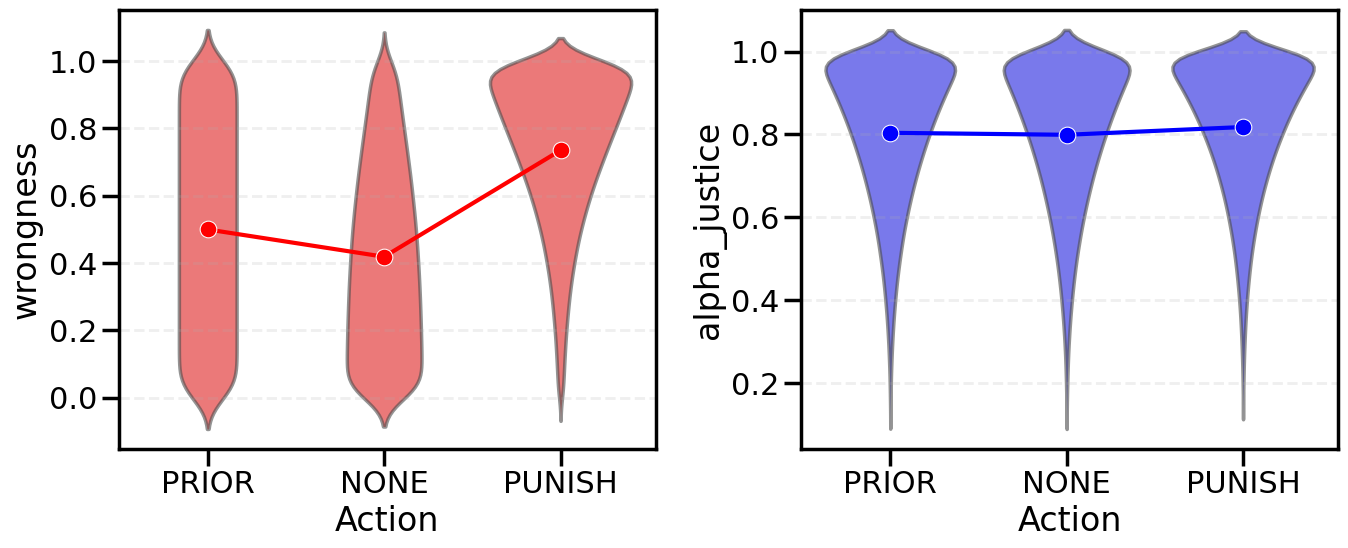

In [369]:
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=False)

# Plot the distributions in subplots
plot_distribution(axes[0], wrongness_dist, wrongness_value, variable_name='wrongness')
plot_distribution(axes[1], alpha_justice_dist, alpha_justice_value, variable_name='alpha_justice')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()